In [1]:
using DrWatson

@quickactivate "Hadjivasiliou_Julia_Tutorial"

projectname()

"Hadjivasiliou_Julia_Tutorial"

In [2]:
using DifferentialEquations
using DiffEqParamEstim
using Distributions
using LinearAlgebra

using Plots
using StatsPlots


using Base.Threads
using Base.Threads: @spawn

using Optim

Next ODE: morphogen gradient - diffusion and linear degradation term

$\frac{\partial c}{\partial t} = D \frac{\partial ^ 2 c}{\partial x ^2}  - kc$

with source term $D\frac{\partial c}{\partial x}|_{x=0} = -j_0$ and zero flux at the end of the tissue, $D\frac{\partial c}{\partial x}|_{x=L} = 0$

The analytic solution $c(x) = c_0\exp(-x/\lambda) + c_1\exp(x/\lambda)$, where $c_0 = \frac{j_0}{\sqrt{Dk}}$ and $\lambda = \sqrt{\frac{D}{k}}$

In [49]:
const Nc = 100
const L = 1.

const tissue = range(0,L,length = Nc)

const dx = step(tissue)
const h = 1/dx^2

const k = 1.
const j0 = 0.4


function morph_grad!(du,u,p,t)

    D = p

    du[1] = h*(2*u[2] + (2*dx*j0/D) - 2*u[1]) - k*u[1]

    @inbounds for j in 2:Nc-1
        du[j] =  D*h*(u[j-1] + u[j+1] - 2*u[j]) - k*u[j]
    end

    du[Nc] = h*(2*u[Nc-1] - 2*u[Nc]) - k*u[Nc]
    
end

morph_grad! (generic function with 1 method)

In [58]:
D = 0.16

p = (D)

u0 = zeros(Nc)

tspan = (0,22.)

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),save_everystep = false);

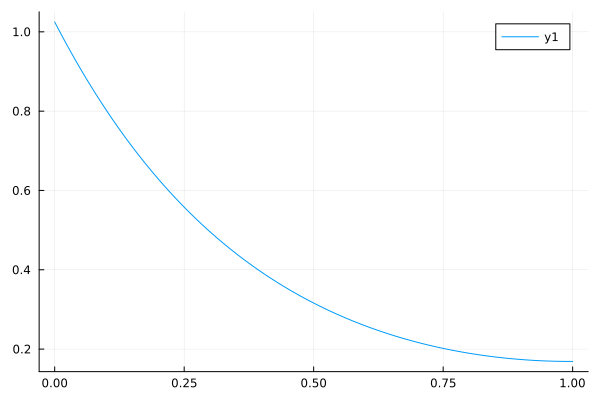

In [59]:
plot(tissue,sol.u[end])

In [60]:
# https://turing.ml/dev/tutorials/10-bayesian-differential-equations/

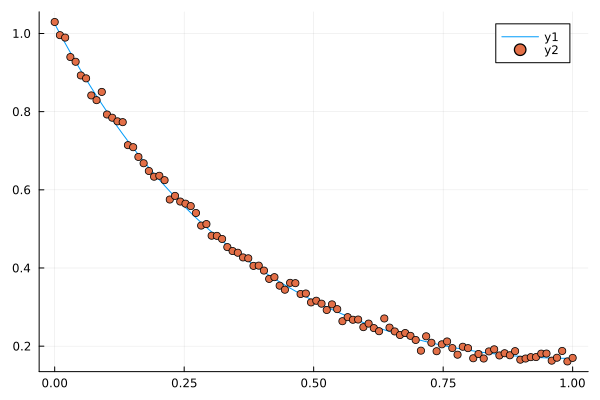

In [61]:
σ_noise = 0.1

d = Normal(0.0,σ_noise^2)

odedata = sol(tspan[2]) .+ rand(d,length(sol(tspan[2])))

plot(tissue,sol.u[end])
scatter!(tissue,odedata)

In [62]:
cost_function = build_loss_objective(prob,AutoTsit5(Rosenbrock23()),L2Loss(tspan[2],odedata),maxiters=1000,verbose = false);

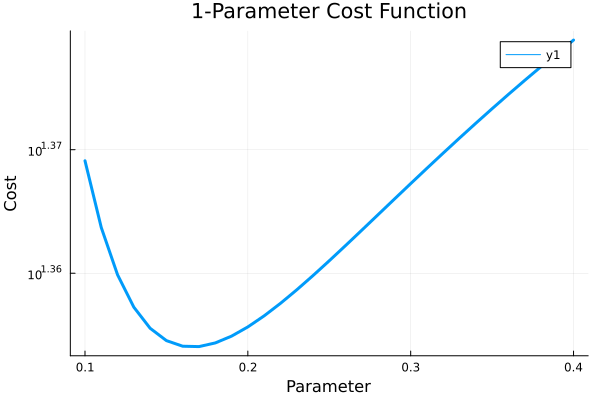

In [63]:
vals = 0.1:0.01:0.4

plot(vals,[cost_function(i) for i in vals],yscale=:log10,
     xaxis = "Parameter", yaxis = "Cost", title = "1-Parameter Cost Function",
     lw = 3)

In [64]:
result = optimize(cost_function, 0.0, 0.4)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 0.400000]
 * Minimizer: 1.657326e-01
 * Minimum: 2.259602e+01
 * Iterations: 15
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 16

In [65]:
result.minimizer[1] 

0.16573259564689846